In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score, recall_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

In [3]:
df = pd.read_parquet("processed_data/agg_data_preprocess_2.gzip")
labels = pd.read_feather("train_labels.ftr")

In [8]:
intersection_labels = np.intersect1d(df["customer_ID"], labels["customer_ID"]).tolist()
df_Y = labels.loc[labels["customer_ID"].isin(intersection_labels),:]


In [14]:
df = df.drop(columns=["customer_ID"])
df_Y = df_Y.drop(columns=["customer_ID"])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, df_Y, test_size=0.20)
print(X_train.shape)
print(X_test.shape)

(367130, 1265)
(91783, 1265)


In [16]:
xgboost_parameters = {
    'verbosity': 1,
    'max_depth':4, 
    'learning_rate':0.04, 
    'subsample':0.71,
    'colsample_bytree':0.72, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'enable_categorical': True
    }

In [17]:
xgb_clf = xgb.XGBClassifier(**xgboost_parameters)
print(xgb_clf.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.72, 'early_stopping_rounds': None, 'enable_categorical': True, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.71, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': 1}


In [18]:
cv_results = cross_validate(xgb_clf, X_train, y_train, cv=5, scoring=('roc_auc', 'precision', 'recall'), return_train_score=True)
print(sorted(cv_results.keys()))

['fit_time', 'score_time', 'test_precision', 'test_recall', 'test_roc_auc', 'train_precision', 'train_recall', 'train_roc_auc']


In [23]:
print("Precision on validation set: " , np.mean(cv_results['test_precision']))
print("Recall on validation set: " , np.mean(cv_results['test_recall']))
print("Roc_auc on validation set: " , np.mean(cv_results['test_roc_auc']))
print("---------------------")
print("Precision on train set: " , np.mean(cv_results['train_precision']))
print("Recall on train set: " , np.mean(cv_results['train_recall']))
print("Roc_auc on train set: " , np.mean(cv_results['train_roc_auc']))


Precision on validation set:  0.7943869285656847
Recall on validation set:  0.7884437639873975
Roc_auc on validation set:  0.9528150601456253
---------------------
Precision on train set:  0.7969693254225312
Recall on train set:  0.7917419450029628
Roc_auc on train set:  0.9541338157981037


In [33]:
def display_metrics(predictor,y_true, y_pred_labels, y_pred_score):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    accuracy = accuracy_score(y_true, y_pred_labels)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_pred_labels)
    print("Precision score: ", precision)
    recall = recall_score(y_true, y_pred_labels)
    print("Recall score: ", recall)
    f1 = f1_score(y_true, y_pred_labels)
    print("F1 score: ", f1)
    rocauc = roc_auc_score(y_true, y_pred_labels)
    print("roc_auc score: ", rocauc)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)
    fpr, tpr, _ = roc_curve(y_true, y_pred_score[:, 1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=predictor.classes_).plot(ax=ax1)

In [34]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.72,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Accuracy:  0.8935690354915152
Precision score:  0.7967643015755524
Recall score:  0.7914583420864669
F1 score:  0.7941024587140494
roc_auc score:  0.8603886739962427


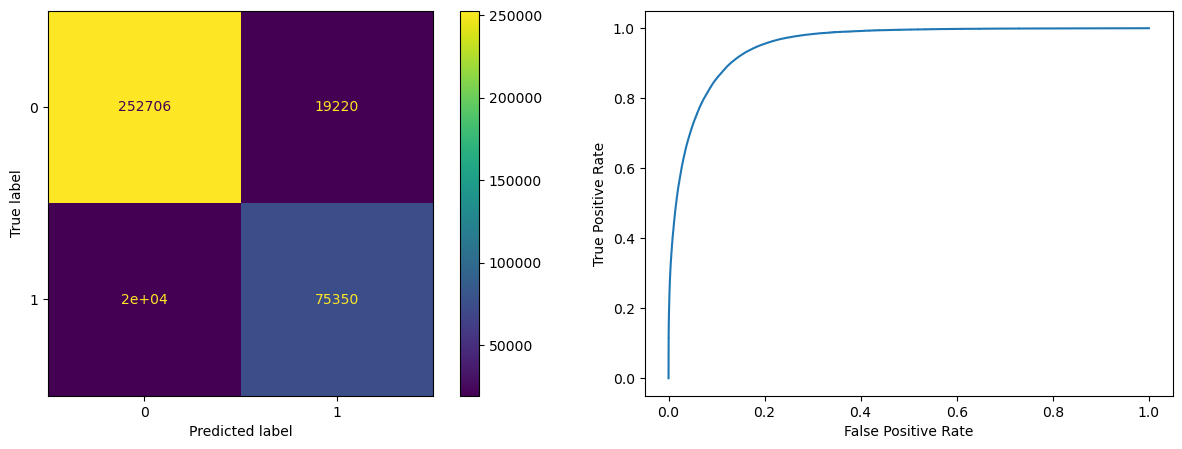

In [36]:
pred_train = xgb_clf.predict(X_train)
pred_proba_train = xgb_clf.predict_proba(X_train)
display_metrics(xgb_clf, y_train, pred_train, pred_proba_train)

Accuracy:  0.8909275138097469
Precision score:  0.7912120823172036
Recall score:  0.7828056214019641
F1 score:  0.7869864033874503
roc_auc score:  0.8556041634203587


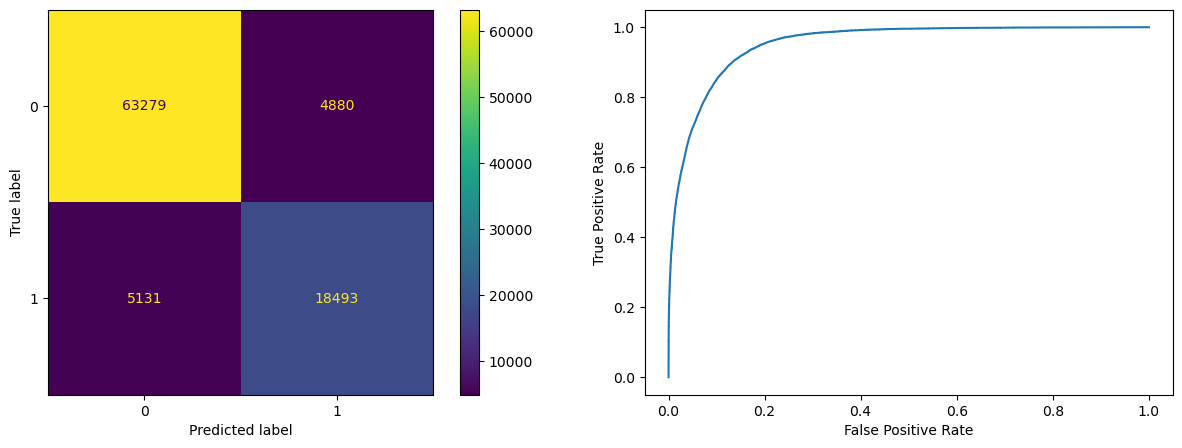

In [35]:
pred_test = xgb_clf.predict(X_test)
pred_prob = xgb_clf.predict_proba(X_test)
display_metrics(xgb_clf, y_test, pred_test, pred_prob)